# Projects

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgitlab.in2p3.fr%2Fenergy4climate%2Fpublic%2Feducation%2Fmachine_learning_for_climate_and_energy/master?filepath=book%2Fnotebooks%2Fprojects.ipynb)

<div class="alert alert-block alert-warning">
    <b>Schedule</b>
    
- Ask your supervisors for the data if not already provided (it is not included in this repository).
- Quick presentation.
- Final project presentation.
    
</div>

<div class="alert alert-block alert-info">
    <b>One problematic, One dataset, One (or more) method(s)</b>
    
- Quality of the dataset is key.
- Results on a clean notebook.
- Explain which method(s) you used and why.
- If a method fails, explain why.

</div>

## Variable Renewable Energy (VRE) assessment and forecast

### Project objectives
<div class="alert alert-block alert-info">

- Assess the onshore wind or solar photovoltaic hourly production over in metropolitan France regions using climate data and capacity factor observations.
- Predict the VRE power ahead of time.
</div>

### Dataset

- Observed monthly VRE capacity factors averaged over metropolitan France regions from 2014 to 2019
- Climate variables of your choice from a global reanalysis with an hourly sampling

### First steps

- Choose from solar or wind power
- Read about solar/wind production assessment and forecast
- Estimate the hourly solar/wind production

### Reading the data

<AxesSubplot:xlabel='time'>

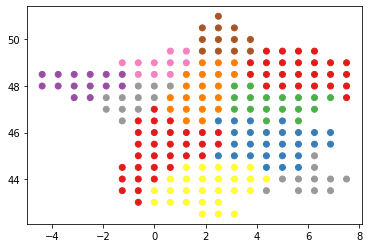

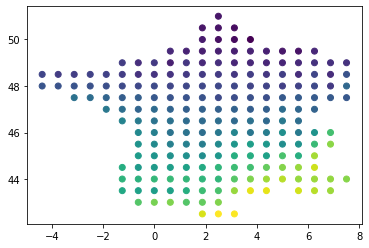

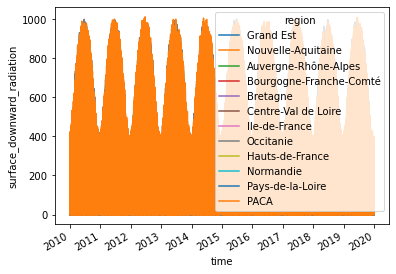

<Figure size 432x288 with 0 Axes>

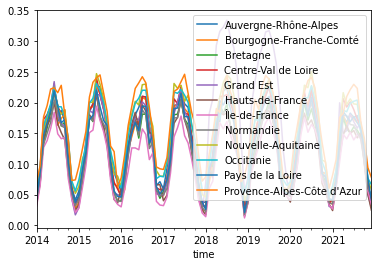

In [61]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Directories where you saved the data
data_dir_energy = Path('data/projects/energy_france')
data_dir_climate = Path('data/projects/climate_france')
                        
# Template filenames
filename_mask = 'mask_datagouv_french_regions_merra2_Nx_France.nc'
filename_climate = 'merra2_area_selection_output_{}_merra2_2010-2019.nc'
filename_energy = 'reseaux_energies_{}.csv'

# Read and plot grid point-region mask
filepath_mask = Path(data_dir_climate, filename_mask)
ds_mask = xr.load_dataset(filepath_mask)
da_mask = ds_mask['mask']
plt.figure()
plt.scatter(da_mask['lon'], da_mask['lat'], c=da_mask, cmap='Set1')

# Read a climate variable and plot its mean over time
variable_name = 'surface_downward_radiation'
filename = filename_climate.format(variable_name)
filepath = Path(data_dir_climate, filename)
da_climate = xr.load_dataset(filepath)[variable_name]
plt.figure()
plt.scatter(da_mask['lon'], da_mask['lat'], c=da_climate.mean('time'))

# Compute regional mean of climate variable and plot time series
da_climate_reg = da_climate.groupby(da_mask).mean().rename(mask='region')
da_climate_reg['region'] = ds_mask['region'].values
plt.figure()
da_climate_reg.plot.line(x='time')

# Read energy variable and plot time series
variable_name = 'capacityfactor_pv'
filename = filename_energy.format(variable_name)
filepath = Path(data_dir_energy, filename)
df_energy = pd.read_csv(filepath, index_col=0, header=0, parse_dates=True)
plt.figure()
df_energy.plot()

# DATA PREPROCESSING

In [46]:
# Selection of region from list below
region = 'Ile-de-France'
regions = ['Grand Est', 'Nouvelle-Aquitaine', 'Auvergne-Rhône-Alpes',
       'Bourgogne-Franche-Comté', 'Bretagne', 'Centre-Val de Loire',
       'Ile-de-France', 'Occitanie', 'Hauts-de-France', 'Normandie',
       'Pays-de-la-Loire', 'PACA']

# Gathering climate data into a dataframe
climate_variable_names = ['height_500', 'surface_density', 
                          'surface_downward_radiation', 'surface_specific_humidity',
                         'surface_temperature', 'upper_meridional_wind', 'upper_zonal_wind',
                         'zonal_wind', 'meridional_wind']

for variable in climate_variable_names:
    filename = filename_climate.format(variable)
    filepath = Path(data_dir_climate, filename)
    da_climate = xr.load_dataset(filepath)[variable]
    da_climate_reg = da_climate.groupby(da_mask).mean().rename(mask='region')
    da_climate_reg['region'] = ds_mask['region'].values
    df_climate = da_climate_reg.to_pandas()
    if variable != climate_variable_names[0]:
        df_climate_reg[variable] = pd.DataFrame(df_climate[region])
    else:
        df_climate_reg = pd.DataFrame(df_climate[region]).rename(columns ={region:variable})
df_climate_reg_monthly = df_climate_reg.resample('MS').mean()
df_climate_reg_monthly



,height_500,surface_density,surface_downward_radiation,surface_specific_humidity,surface_temperature,upper_meridional_wind,upper_zonal_wind,zonal_wind,meridional_wind
time,,,,,,,,,
2010-01-01,5431.350586,1.277740,43.559608,0.003301,272.273590,-0.394260,0.350395,0.113088,-0.318379
2010-02-01,5351.853027,1.250808,71.057159,0.004014,275.193329,2.338912,2.226946,1.520094,1.633788
2010-03-01,5505.052246,1.250952,141.006073,0.004432,278.706116,0.467306,0.289097,0.139313,0.279691
2010-04-01,5592.165039,1.233363,226.640030,0.005089,283.016418,-1.213971,-0.499806,-0.329032,-0.835640
2010-05-01,5595.019531,1.221154,260.374359,0.006000,284.744049,-3.403135,0.313585,0.289953,-2.414946
...,...,...,...,...,...,...,...,...,...
2019-08-01,5764.394531,1.186036,228.612228,0.008507,293.096375,0.466144,1.932216,1.408895,0.461117
2019-09-01,5749.764648,1.206204,190.179092,0.007319,289.145721,-0.181627,1.497324,1.105618,-0.042446
2019-10-01,5654.728027,1.215386,93.818886,0.007387,285.335632,2.770181,2.270087,1.522698,1.881359


In [39]:
# Rename columns of capacity factor data
df_energy = df_energy.rename(columns = {'Île-de-France':'Ile-de-France',
                           'Provence-Alpes-Côte d\'Azur':'PACA', 'Pays de la Loire':'Pays-de-la-Loire'})
df_energy_reg = pd.DataFrame(df_energy[region]).rename(columns = {region: 'CF_'+region})
df_energy_reg

,CF_Ile-de-France
time,
2014-01-01,0.0310
2014-02-01,0.0640
2014-03-01,0.1270
2014-04-01,0.1380
2014-05-01,0.1580
...,...
2021-08-01,0.1482
2021-09-01,0.1400
2021-10-01,0.1056


In [40]:
# Set the features and output data to common index
common_index = df_climate_reg_monthly.index.intersection(df_energy_reg.index)

# Joining the input features and target data in the same dataframe
df_climate = df_climate_reg_monthly.loc[common_index]
df_energy = df_energy_reg.loc[common_index]
df_climate_energy = pd.concat([df_climate, df_energy], axis = 1)
df_climate_energy

,height_500,surface_density,surface_downward_radiation,surface_specific_humidity,surface_temperature,upper_meridional_wind,upper_zonal_wind,zonal_wind,meridional_wind,CF_Ile-de-France
time,,,,,,,,,,
2014-01-01,5441.876465,1.239541,35.078514,0.005184,278.326843,5.413025,2.201480,1.457212,3.932577,0.031
2014-02-01,5407.690918,1.236099,66.375504,0.004937,278.731354,6.872248,3.462634,2.368809,4.987933,0.064
2014-03-01,5576.235352,1.237386,150.002029,0.004942,281.533936,1.120855,0.462770,0.433149,0.747019,0.127
2014-04-01,5591.039062,1.222223,203.017075,0.006059,284.320435,0.195392,0.329754,0.240969,0.179756,0.138
2014-05-01,5610.685547,1.216665,242.731064,0.006797,285.875427,0.683228,1.622033,1.160403,0.544363,0.158
...,...,...,...,...,...,...,...,...,...,...
2019-08-01,5764.394531,1.186036,228.612228,0.008507,293.096375,0.466144,1.932216,1.408895,0.461117,0.155
2019-09-01,5749.764648,1.206204,190.179092,0.007319,289.145721,-0.181627,1.497324,1.105618,-0.042446,0.132
2019-10-01,5654.728027,1.215386,93.818886,0.007387,285.335632,2.770181,2.270087,1.522698,1.881359,0.081


In [85]:
#scale data
scaler=MinMaxScaler(feature_range=(0,1))

df_climate_energy_scaled = pd.DataFrame(scaler.fit_transform(df_climate_energy))

new_names = list(df_climate_energy.columns)
old_names = df_climate_energy_scaled.columns

for i in range(len(new_names)):
    df_climate_energy_scaled = df_climate_energy_scaled.rename(columns={i:new_names[i]})

df_climate_energy_scaled.head()

,height_500,surface_density,surface_downward_radiation,surface_specific_humidity,surface_temperature,upper_meridional_wind,upper_zonal_wind,zonal_wind,meridional_wind,CF_Ile-de-France
0,0.101889,0.574878,0.017139,0.279972,0.237584,0.848795,0.602987,0.579165,0.847143,0.104396
1,0.017307,0.542571,0.134146,0.243760,0.256439,1.000000,0.794519,0.788096,1.000000,0.285714
2,0.434320,0.554648,0.446792,0.244421,0.387074,0.404041,0.338927,0.344456,0.385748,0.631868
3,0.470947,0.412346,0.644993,0.408358,0.516960,0.308144,0.318726,0.300410,0.303586,0.692308
4,0.519556,0.360186,0.793468,0.516594,0.589442,0.358694,0.514986,0.511138,0.356395,0.802198


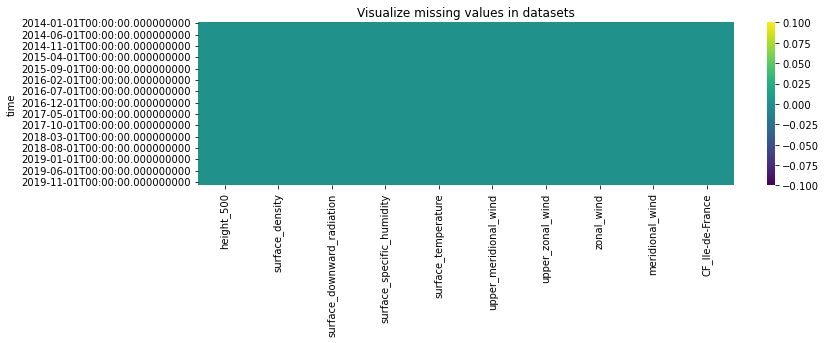

In [41]:
# Check fro input data
plt.figure(figsize=(12, 3))
sns.heatmap(df_climate_energy.isnull(), cmap='viridis');
plt.title('Visualize missing values in datasets');

# DATA ANALYSIS

### Features selection with Pearson correlation

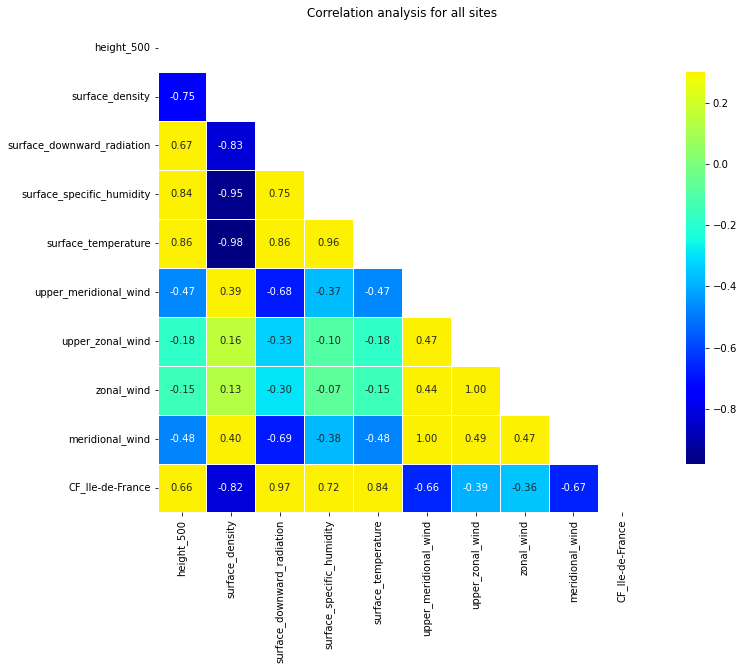

In [91]:
# Check correlation between all the scaled data

# Correlation matrix
df_climate_energy_scaled_corr = df_climate_energy_scaled.corr()
mask = np.triu(np.ones_like(df_climate_energy_scaled_corr, dtype=bool))

# Plot of correlation heatmap
fig, ax = plt.subplots(figsize=(14, 9))
sns.heatmap(df_climate_energy_scaled_corr, mask=mask, cmap='jet', vmax=.3, center=0, annot=True, fmt='.2f',
            square=True, linewidths=.5, cbar_kws={"shrink": .8});
plt.title('Correlation analysis for all sites');

In [60]:
selcted_features = []

# Selection of features based on a correlation thresold

# df_climate_energy_corr[df_climate_energy_corr.loc['CF_Ile-de-France', :] > 0.8]
df_climate_energy_corr.columns

Index(['height_500', 'surface_density', 'surface_downward_radiation',
       'surface_specific_humidity', 'surface_temperature',
       'upper_meridional_wind', 'upper_zonal_wind', 'zonal_wind',
       'meridional_wind', 'CF_Ile-de-France'],
      dtype='object')

### Features selection with Lasso regression

# MODEL SELECTION